# Line pattern - detailed analysis

## Introduction
The excercise is to comapare a reference lithography pattern saved in GDSII 
format to a device imaged with TEM. The reference pattern is lines from 50 to 0.5um in 
size with 15um spacing. 

Typical tasks required for the analysis includes imaging the structures, verifying 
their dimensions, and identifying any defects in, and yield of, the devices 
vs. designed parameters.

### Excercise
Considering the image below, please write code to automatically determine the 
features, their dimensions and analyse the data that you get from this, and include 
the results in the report as if you were providing feedback to the fabrication team.  
(High quality image of below is attached along the design file used to make this as a 
gds file. To read the gds file you can download and install Klayout or use any other 
layout editor of your choice) 

## Analysis
Import the libraries we're going to need.

In [1]:
# Helpers for Google colab
# %pip install scikit-image

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import measure
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import rescale

C:\Users\RowanTemple\miniconda3\envs\sandbox310\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## Load and binarize image
Load the TEM image file and visually check it:

Successfully laded TEM image. Dimension:  (2168, 2168, 3)


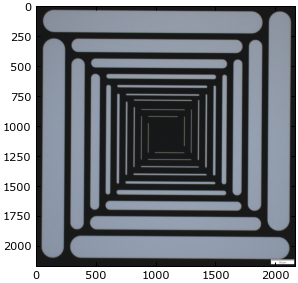

In [3]:
fp = "./data/Photolith pattern.png"
rdat = plt.imread(fp)

print("Successfully laded TEM image. Dimension: ", rdat.shape)
plt.imshow(rdat)

Convert to gray scale. Binarize the image using Otsu thresholding technique. This will search for the best threshold on a generalised image even if the thresholds change.

In [4]:
dat = rgb2gray(rdat)
thresh = threshold_otsu(dat)
binary = (dat > thresh).astype(np.uint8)

Plot the greyscale colour histogram to check the Otsu threshold chosen looks reasonable.

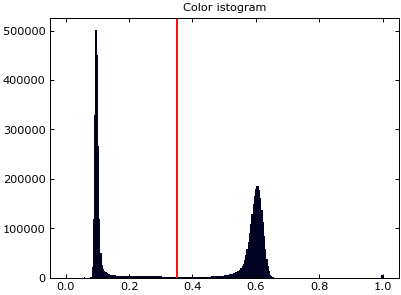

In [5]:
plt.hist(dat.ravel(), bins=256)
plt.title('Color istogram')
plt.axvline(thresh, color='r')

OK the threshold looks good.

Now let's visually check the binarisation process:

Same plot with zoom:


Text(0.5, 1.0, 'Binarised')

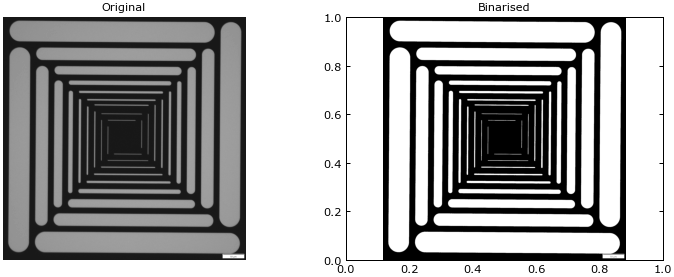

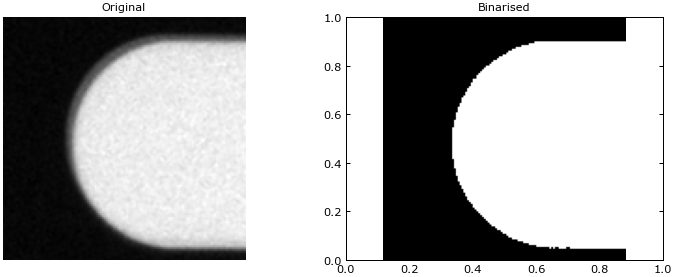

In [8]:
def create_image_comparison_figure():
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 2, 1)
    ax[1] = plt.subplot(1, 2, 2, sharex=ax[0], sharey=ax[0])
    [ax[i].axis('off') for i in range(2)]
    return ax


ax0, ax1 = create_image_comparison_figure()
ax0.imshow(dat, cmap="gray")
ax0.set_title('Original')
ax1.imshow(binary, cmap="gray")
ax1.set_title('Binarised')

# zoom in
print("Same plot with zoom:")
ax0, ax1 = create_image_comparison_figure()
shpi, shpj = dat.shape
crop = (slice(round(shpi * 0.12), round(shpi * 0.18)),
        slice(round(shpj * 0.12), round(shpj * 0.18)))
ax0.imshow(dat[crop], cmap="gray")
ax0.set_title('Original')
ax1.imshow(binary[crop], cmap="gray")
ax1.set_title('Binarised')

At a high level the binary mask matches the image well. When we zoom in we see the image boundary is not well defined. There is blur at the edges, probably due to shadowing or other defects during the lithography. In addition our mask is quite pixelated. We can help solve the latter problem by resizing the image to 3x pixel density.

Text(0.5, 1.0, 'Binarised after rescale')

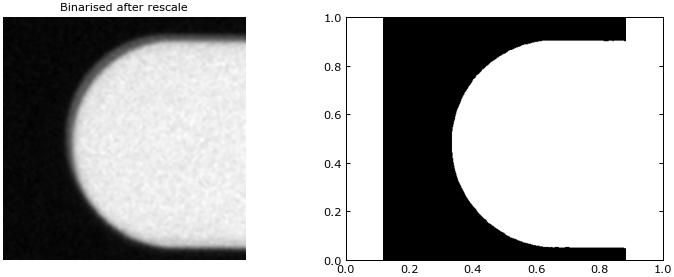

In [9]:
scaling_factor = 3
dat = rescale(dat, scaling_factor)
binary = (dat > thresh).astype(np.uint8)

ax0, ax1 = create_image_comparison_figure()
shpi, shpj = dat.shape
crop = (slice(round(shpi * 0.12), round(shpi * 0.18)),
        slice(round(shpj * 0.12), round(shpj * 0.18)))
ax0.imshow(dat[crop], cmap="gray")
ax0.set_title('Original after 3x resize')
ax1.imshow(binary[crop], cmap="gray")
ax0.set_title('Binarised after rescale')

We've got more detail on the mask now and the edges are smoother. The lithography shadowing effect is still present in the real image and the mask size is reflecting this. We can probably expect that the bar widths are going to be wider than the bar widths in the GDS file.

## Scale the image using scale bar

If we want to automate scaling (finding the image physical dimension). We need to isolate the scale bar on bottom right of the image. This is likely to be in the same pixel position each time for a given instrument so we can just hard code the coordinates of the bar. We'd have to revise this if the position wasn't consistent and do some kind of particle detection method to find the bar.

The 50um scale line width is 184 pixels. The total image size is 589.130 um x 589.130 um


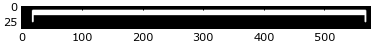

In [10]:
coord = np.array([2115, 1959, 2127, 2151]) * scaling_factor
scale_line_y = 2118 * scaling_factor
scaleim = np.logical_not(binary[coord[0]:coord[2], coord[1]:coord[3]])
scale_lw = np.sum(scaleim[scale_line_y - coord[0], :])
pix_to_um = 50 / scale_lw
fig, ax = plt.subplots(1, 1)
ax.imshow(scaleim, cmap="gray")
print(f"The 50um scale line width is {round(scale_lw / scaling_factor)} pixels. "
      f"The total image size is {binary.shape[1] * pix_to_um:.3f} um x "
      f"{binary.shape[0] * pix_to_um:.3f} um")

### Test scale
Let's double check the scale manually. From a visual inspection using ImageJ software I measure 184 pixels, verifying that the automated process has got an accurate value.
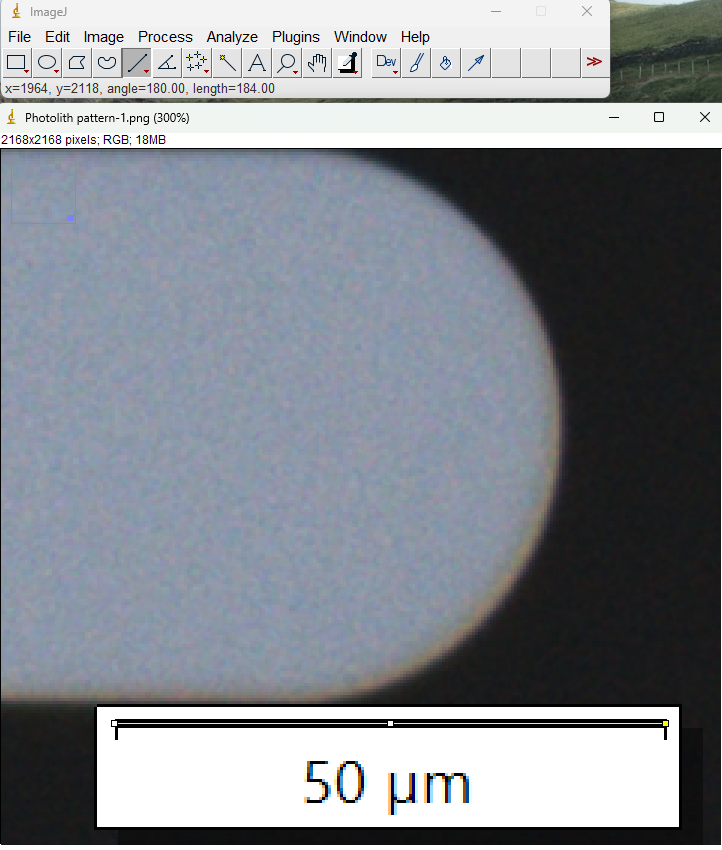

## Analyse bars
OK now we want to detect and analyse the bar pattern.

First detect and measure the properties of all the features in the image.

In [11]:
label_image = measure.label(binary)
properties = measure.regionprops(label_image)

df = {
    prop.label: {
        "device_label": "sample_1",
        "image": "Photolith pattern.png",
        "x_centre_pixels": prop.centroid[1] / scaling_factor,
        "y_centre_pixels": prop.centroid[0] / scaling_factor,
        "width_pix": (prop.bbox[3] - prop.bbox[1]) / scaling_factor,
        "height_pix": (prop.bbox[2] - prop.bbox[0]) / scaling_factor,
        "width": (prop.bbox[3] - prop.bbox[1]) * pix_to_um,
        "height": (prop.bbox[2] - prop.bbox[0]) * pix_to_um,
        "area": prop.area * pix_to_um ** 2,
        "circumference": prop.perimeter * pix_to_um
    } for prop in properties
}
df = pd.DataFrame().from_dict(df, orient="index")
df.index.label = "feature_n"
print(f"Feature properties (lengths in units of um unless specified as number of pixels):")
print(df.head(5))
# print(df.iloc[:10, 2:])

Feature properties (lengths in units of um unless specified as number of pixels):
  device_label                  image  x_centre_pixels  y_centre_pixels  \
1     sample_1  Photolith pattern.png       973.973439       131.371962   
2     sample_1  Photolith pattern.png      2027.829742       960.031105   
3     sample_1  Photolith pattern.png       145.518185      1184.701089   
4     sample_1  Photolith pattern.png      1009.430580       332.753430   
5     sample_1  Photolith pattern.png      1826.441245       995.647272   

     width_pix   height_pix       width      height          area  \
1  1829.333333   196.333333  497.101449   53.351449  24335.633927   
2   196.000000  1827.666667   53.260870  496.648551  24289.023118   
3   196.000000  1827.666667   53.260870  496.648551  24389.998162   
4  1425.333333   120.000000  387.318841   32.608696  11482.184349   
5   120.666667  1425.000000   32.789855  387.228261  11522.625236   

   circumference  
1    1081.192933  
2    1081.6598

Now visualise this result to verify the particle detection has worked well.

(4553.0, 1951.0)

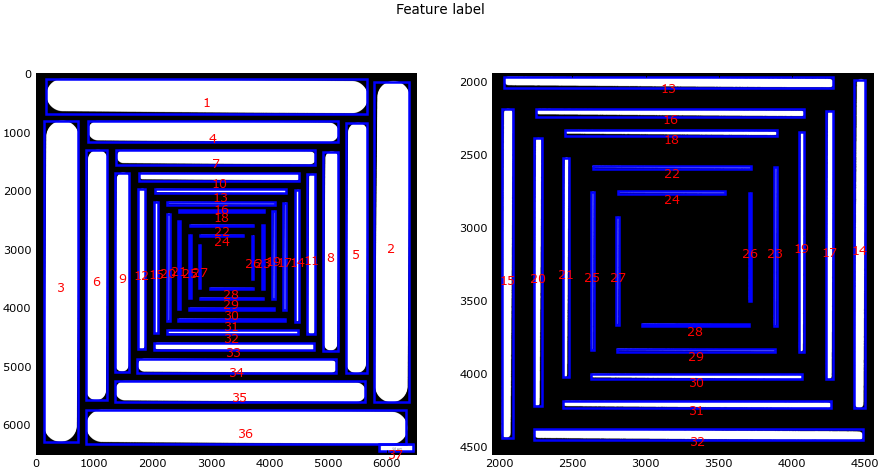

In [12]:
def plot_bboxes(ax, properties):
    for prop in properties:
        # Draw bounding box
        minr, minc, maxr, maxc = prop.bbox
        ax.add_patch(plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                   edgecolor='blue', facecolor='none', lw=2))


xlims = round(0.3 * binary.shape[1]), round(0.7 * binary.shape[1])
ylims = round(0.7 * binary.shape[0]), round(0.3 * binary.shape[0])

# Plot labels
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax0, ax1 = ax.ravel()
ax0.imshow(binary, cmap="gray")
plt.suptitle("Feature label")
plot_bboxes(ax0, properties)
for prop in properties:
    ax0.text(prop.centroid[1], prop.centroid[0], f"{prop.label}",
             color='red', fontsize=10, ha='center', va='top')

ax1.imshow(binary, cmap="gray")
plot_bboxes(ax1, properties)

for prop in properties:
    x, y = prop.centroid[1], prop.centroid[0]
    if (xlims[0] <= x <= xlims[1]) and (ylims[1] <= y <= ylims[0]):
        ax1.text(x, y, f"{prop.label}",
                 color='red', fontsize=10, ha='center', va='top')
ax1.set_xlim(*xlims)
ax1.set_ylim(*ylims)

The detection has gone well. All major features have bounding boxes outlined in blue. The random label assigned to each feature is given in red. This corresponds to the feature_n index in the table above.

We can show the feature widths and heights using a similar method:

(4553.0, 1951.0)

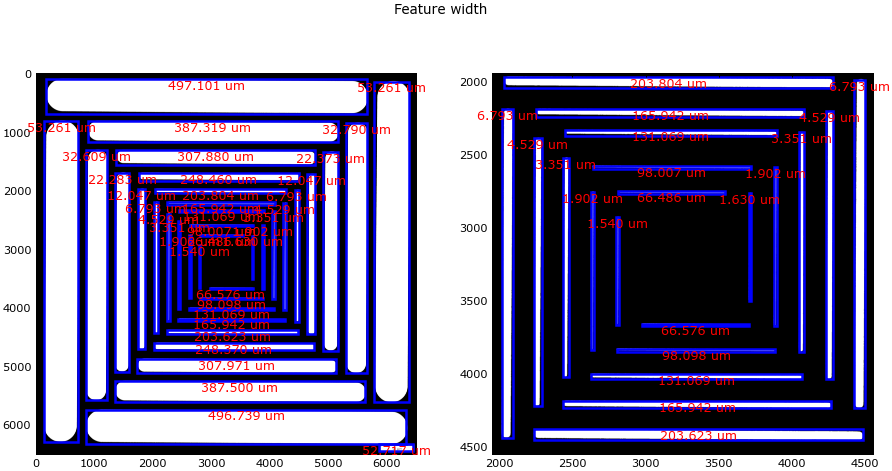

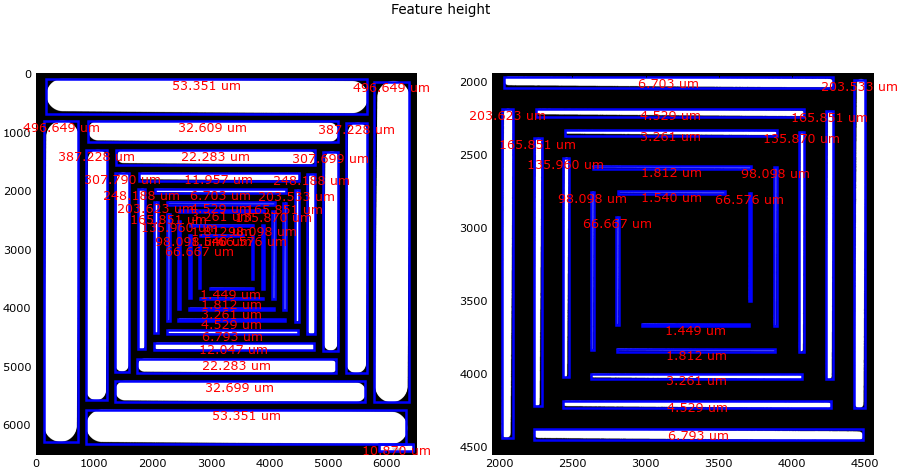

In [13]:
# Plot widths
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax0, ax1 = ax.ravel()
ax0.imshow(binary, cmap="gray")
plt.suptitle("Feature width")
plot_bboxes(ax0, properties)
for prop in properties:
    # Annotate particle properties
    ax0.text(prop.centroid[1], prop.bbox[0],
             f"{(prop.bbox[3] - prop.bbox[1]) * pix_to_um:.3f} um",
             color='red', fontsize=10, ha='center', va='top')

ax1.imshow(binary, cmap="gray")
plot_bboxes(ax1, properties)
for prop in properties:
    x, y = prop.centroid[1], prop.centroid[0]
    if (xlims[0] <= x <= xlims[1]) and (ylims[1] <= y <= ylims[0]):
        ax1.text(prop.centroid[1], prop.bbox[0],
                 f"{(prop.bbox[3] - prop.bbox[1]) * pix_to_um:.3f} um",
                 color='red', fontsize=10, ha='center', va='top')
ax1.set_xlim(*xlims)
ax1.set_ylim(*ylims)

# Plot heights
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax0, ax1 = ax.ravel()
ax0.imshow(binary, cmap="gray")
plt.suptitle("Feature height")
plot_bboxes(ax0, properties)
for prop in properties:
    # Annotate particle properties
    ax0.text(prop.centroid[1], prop.bbox[0],
             f"{(prop.bbox[2] - prop.bbox[0]) * pix_to_um:.3f} um",
             color='red', fontsize=10, ha='center', va='top')

ax1.imshow(binary, cmap="gray")
plot_bboxes(ax1, properties)
for prop in properties:
    x, y = prop.centroid[1], prop.centroid[0]
    if (xlims[0] <= x <= xlims[1]) and (ylims[1] <= y <= ylims[0]):
        ax1.text(prop.centroid[1], prop.bbox[0],
                 f"{(prop.bbox[2] - prop.bbox[0]) * pix_to_um:.3f} um",
                 color='red', fontsize=10, ha='center', va='top')
ax1.set_xlim(*xlims)
ax1.set_ylim(*ylims)

We can already see the smaller bars have widths significantly greater than the desired widths. For instance the narrowest bars have widths around 1.5um and a target width of 0.5um.

# Analyse lithography performance

We'd like to compare the measured bar width to the target bar width (taken from the gds file pattern). Here we're going to manually map the detected feature_n labels to the bar type and expected bar width. In practice if we were automating this process over a lot of images of a similar pattern we'd find a robust way to do this mapping automatically. Probably by ranking by particle size and position within the image.

In [14]:
# Drop feature 37 which is the scale bar
df = df.drop(37)

label_map = {
    'vertical_left': [3, 6, 9, 12, 15, 20, 21, 25, 27],
    'vertical_right': [2, 5, 8, 11, 14, 17, 19, 23, 26],
    'horizontal_top': [1, 4, 7, 10, 13, 16, 18, 22, 24],
    'horizontal_bottom': [36, 35, 34, 33, 32, 31, 30, 29, 28]
}

# expected width in microns
expected_width = [50, 30, 20, 10, 5, 3, 2, 1, 0.5]


for idx, row in df.iterrows():
    bar_type = [k for k, v in label_map.items() if idx in v][0]
    expected_bar_width = expected_width[label_map[bar_type].index(idx)]
    actual_bar_width = row["width"] if row["width"] < row["height"] else row["height"]
    df.loc[idx, "bar_type"] = bar_type
    df.loc[idx, "expected_bar_width"] = expected_bar_width
    df.loc[idx, "actual_bar_width"] = actual_bar_width

print(df[["bar_type", "expected_bar_width", "actual_bar_width"]])

             bar_type  expected_bar_width  actual_bar_width
1      horizontal_top                50.0         53.351449
2      vertical_right                50.0         53.260870
3       vertical_left                50.0         53.260870
4      horizontal_top                30.0         32.608696
5      vertical_right                30.0         32.789855
6       vertical_left                30.0         32.608696
7      horizontal_top                20.0         22.282609
8      vertical_right                20.0         22.373188
9       vertical_left                20.0         22.282609
10     horizontal_top                10.0         11.956522
11     vertical_right                10.0         12.047101
12      vertical_left                10.0         12.047101
13     horizontal_top                 5.0          6.702899
14     vertical_right                 5.0          6.793478
15      vertical_left                 5.0          6.793478
16     horizontal_top                 3.

Visualise the difference and ratio for the bar widths

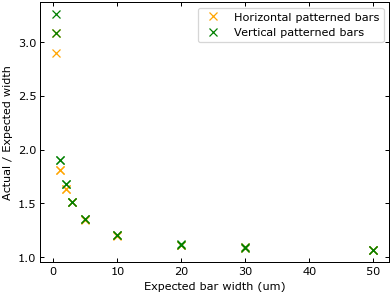

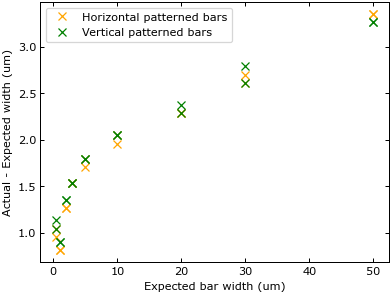

In [15]:
fig, ax = plt.subplots(1, 1)
sub1 = df.loc[df["bar_type"].str.startswith("horizontal")]
sub2 = df.loc[df["bar_type"].str.startswith("vertical")]
plt.plot(sub1["expected_bar_width"], sub1["actual_bar_width"] / sub1["expected_bar_width"], "x", label="Horizontal patterned bars", color="orange")
plt.plot(sub2["expected_bar_width"], sub2["actual_bar_width"] / sub2["expected_bar_width"], "gx", label="Vertical patterned bars")
plt.xlabel("Expected bar width (um)")
plt.ylabel("Actual / Expected width")
plt.legend()

fig, ax = plt.subplots(1, 1)
sub1 = df.loc[df["bar_type"].str.startswith("horizontal")]
sub2 = df.loc[df["bar_type"].str.startswith("vertical")]
plt.plot(sub1["expected_bar_width"], sub1["actual_bar_width"] - sub1["expected_bar_width"], "x", label="Horizontal patterned bars", color="orange")
plt.plot(sub2["expected_bar_width"], sub2["actual_bar_width"] - sub2["expected_bar_width"], "gx", label="Vertical patterned bars")
plt.xlabel("Expected bar width (um)")
plt.ylabel("Actual - Expected width (um)")
plt.legend()